In [10]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [11]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [12]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [13]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [14]:
len(main_df)

775

In [15]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [16]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





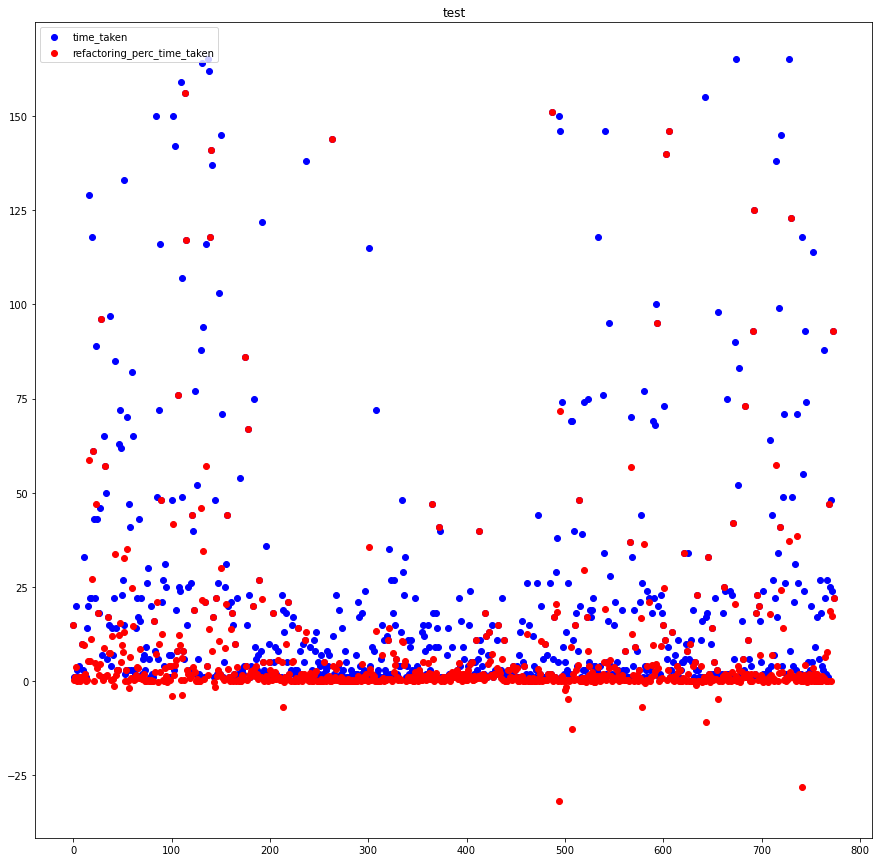

In [17]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [18]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [19]:
main_df['refactoring_perc_time_taken'].value_counts()

11.000000    6
18.000000    5
15.000000    4
10.000000    4
17.000000    4
            ..
9.487500     1
29.600000    1
20.454545    1
11.963636    1
12.985075    1
Name: refactoring_perc_time_taken, Length: 112, dtype: int64

In [20]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [21]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [22]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x18240ca1240>,
 'caps': [<matplotlib.lines.Line2D at 0x18240ca1978>,
 'boxes': [<matplotlib.lines.Line2D at 0x18240ca10f0>],
 'medians': [<matplotlib.lines.Line2D at 0x18240cc4080>],
 'fliers': [<matplotlib.lines.Line2D at 0x18240cc4400>],
 'means': []}

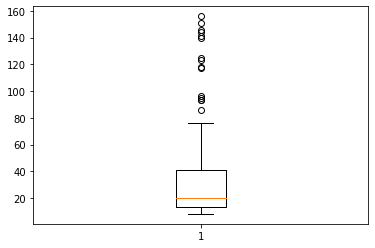

In [23]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x18240c58b70>,
 'caps': [<matplotlib.lines.Line2D at 0x18240c642e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x18240c58a20>],
 'medians': [<matplotlib.lines.Line2D at 0x18240c649e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x18240c64d68>],
 'means': []}

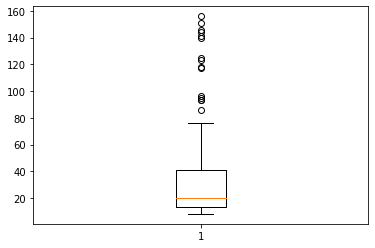

In [24]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [25]:
main_df['time_taken_final'].value_counts()

7.0     11
6.0      9
1.0      9
4.0      6
8.0      6
        ..
3.6      1
61.8     1
40.8     1
29.4     1
19.0     1
Name: time_taken_final, Length: 77, dtype: int64

In [26]:
main_df = main_df.fillna(0)

In [27]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
9,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,9,0.000000,202,1.000000,10.000000,104.52288,62.535928,1285.12,363.273145,6.0
11,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,6,2.121320,400,0.287500,9.487500,206.97600,123.769958,2584.00,572.195617,12.0
0,0,40.561129,1.0,164.0,1.0,6.0,8.0,11.0,18.0,23.0,...,18,4.320494,33,0.454545,58.636364,17.07552,10.220741,176.48,108.889600,14.6
2,0,40.561129,1.0,164.0,1.0,6.0,8.0,11.0,18.0,23.0,...,2,0.707107,523,0.512428,11.273423,270.62112,161.777593,3390.88,683.877406,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3,18.541262,1.0,166.0,1.0,2.0,3.0,4.0,6.0,11.0,...,2,0.000000,2,1.000000,47.000000,1.03488,0.619489,-26.88,16.879500,0.1
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0
4,7,27.645283,1.0,157.0,2.0,4.0,5.0,8.2,13.0,17.0,...,1,0.000000,4,1.000000,93.000000,2.06976,1.238971,-13.76,26.763600,19.4


(array([82., 20., 14.,  7.,  3.,  5.,  0.,  4.,  2.,  4.]),
 array([  8.10810811,  22.8972973 ,  37.68648649,  52.47567568,
         67.26486486,  82.05405405,  96.84324324, 111.63243243,
        126.42162162, 141.21081081, 156.        ]),
 <a list of 10 Patch objects>)

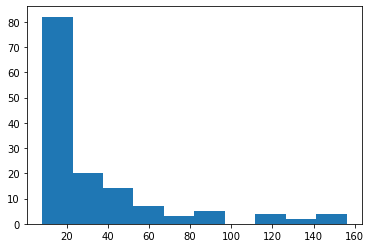

In [28]:
plt.hist(main_df['refactoring_perc_time_taken'])

(array([28., 23., 18., 13.,  6.,  4.,  3.,  7.,  4.,  4.,  6.,  0.,  0.,
         5.,  1.,  1.,  0.,  2.,  1.,  0.,  0.,  1.,  2.,  2.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,
         1.]), array([  8.10810811,  11.80540541,  15.5027027 ,  19.2       ,
         22.8972973 ,  26.59459459,  30.29189189,  33.98918919,
         37.68648649,  41.38378378,  45.08108108,  48.77837838,
         52.47567568,  56.17297297,  59.87027027,  63.56756757,
         67.26486486,  70.96216216,  74.65945946,  78.35675676,
         82.05405405,  85.75135135,  89.44864865,  93.14594595,
         96.84324324, 100.54054054, 104.23783784, 107.93513514,
        111.63243243, 115.32972973, 119.02702703, 122.72432432,
        126.42162162, 130.11891892, 133.81621622, 137.51351351,
        141.21081081, 144.90810811, 148.60540541, 152.3027027 ,
        156.        ]), <a list of 40 Patch objects>)

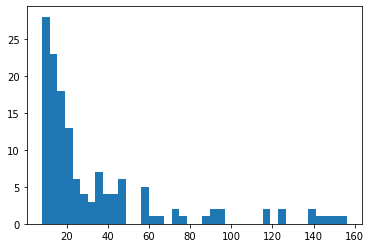

In [29]:
plt.hist(main_df['refactoring_perc_time_taken'],bins=40)

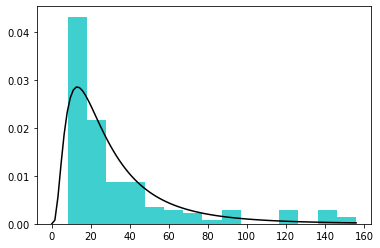

In [30]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

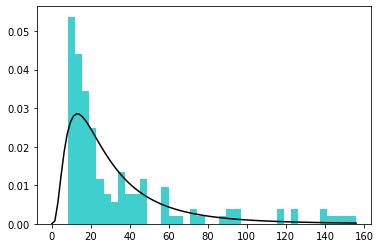

In [31]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

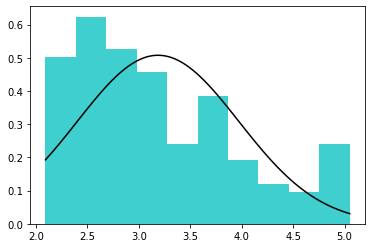

In [32]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [33]:
len(main_df)

141

In [34]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [35]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [36]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [37]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [38]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [39]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [40]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.000000,85.000000,61.000000
9,38.000000,38.0,38.0,0.000000,57.000000,57.0,57.0,0.000000,1.000000,1.0,...,279.000000,279.0,279.0,0.000000,17.000000,17.0,17.0,0.000000,322.000000,764.000000
11,4.000000,4.0,4.0,0.000000,15.000000,15.0,15.0,0.000000,1.000000,1.0,...,108.000000,108.0,108.0,0.000000,1.000000,1.0,1.0,0.000000,371.000000,115.000000
0,4.428571,2.0,9.0,2.507133,1.285714,0.0,3.0,1.380131,1.714286,1.0,...,26.142857,14.0,46.0,10.155927,0.857143,0.0,1.0,0.377964,24.571429,23.285714
2,20.000000,16.0,24.0,5.656854,18.000000,17.0,19.0,1.414214,3.000000,3.0,...,114.500000,97.0,132.0,24.748737,1.000000,1.0,1.0,0.000000,9.500000,272.500000


In [41]:
y.head()

,refactoring_perc_time_taken
0,15.000000
9,10.000000
11,9.487500
0,58.636364
2,11.273423


## Feature Engineering

In [42]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 17 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 10 days !!!
H2O_cluster_name:,H2O_from_python_tanji_8bvj6r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.767 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [43]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [44]:
full.shape

(141, 163)

In [45]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [46]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [47]:
aml = H2OAutoML(max_models=25, seed=16, exclude_algos=['XGBoost','GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |██████
05:09:06.688: Skipping training of model GBM_5_AutoML_20220213_050900 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20220213_050900.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 119.0.


████████████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmp07pu41_z.csv'
███Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpncharxcp.csv'
███Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmp43rhs_td.csv'
██

In [48]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20220213_050900,1307.31,36.1568,1307.31,26.1697,0.844745
StackedEnsemble_AllModels_AutoML_20220213_050900,1317.15,36.2925,1317.15,26.3695,0.854798
GBM_lr_annealing_selection__AutoML_20220213_050900_select_model,1378.78,37.132,1378.78,26.3727,0.875054
DeepLearning_grid__3_AutoML_20220213_050900_model_3,1380.08,37.1494,1380.08,27.32,0.874017
DeepLearning_grid__2_AutoML_20220213_050900_model_2,1381.31,37.166,1381.31,26.2304,nan
GBM_grid__1_AutoML_20220213_050900_model_5,1429.8,37.8126,1429.8,27.191,0.895975
DeepLearning_grid__3_AutoML_20220213_050900_model_1,1523.25,39.0288,1523.25,26.6925,nan
GBM_grid__1_AutoML_20220213_050900_model_9,1530.5,39.1216,1530.5,27.78,0.918243
GBM_4_AutoML_20220213_050900,1573.73,39.6703,1573.73,27.8776,0.9321
GBM_grid__1_AutoML_20220213_050900_model_6,1574.97,39.6859,1574.97,28.0447,0.934447


stackedensemble prediction progress: |████████████████████████████████████| 100%


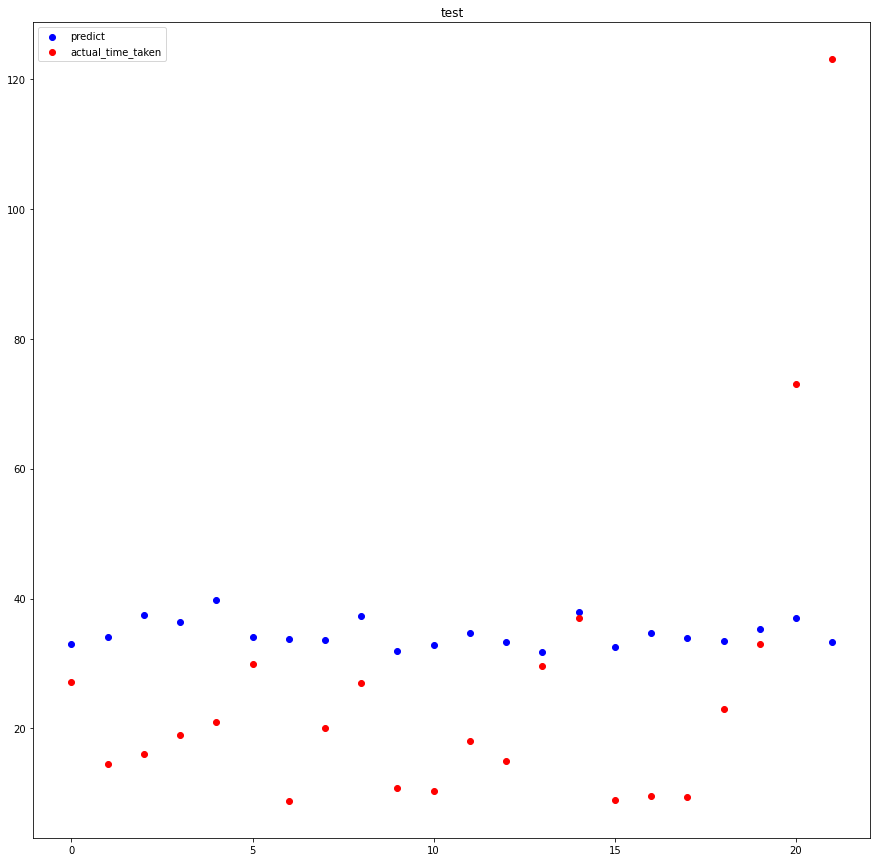

stackedensemble prediction progress: |████████████████████████████████████| 100%


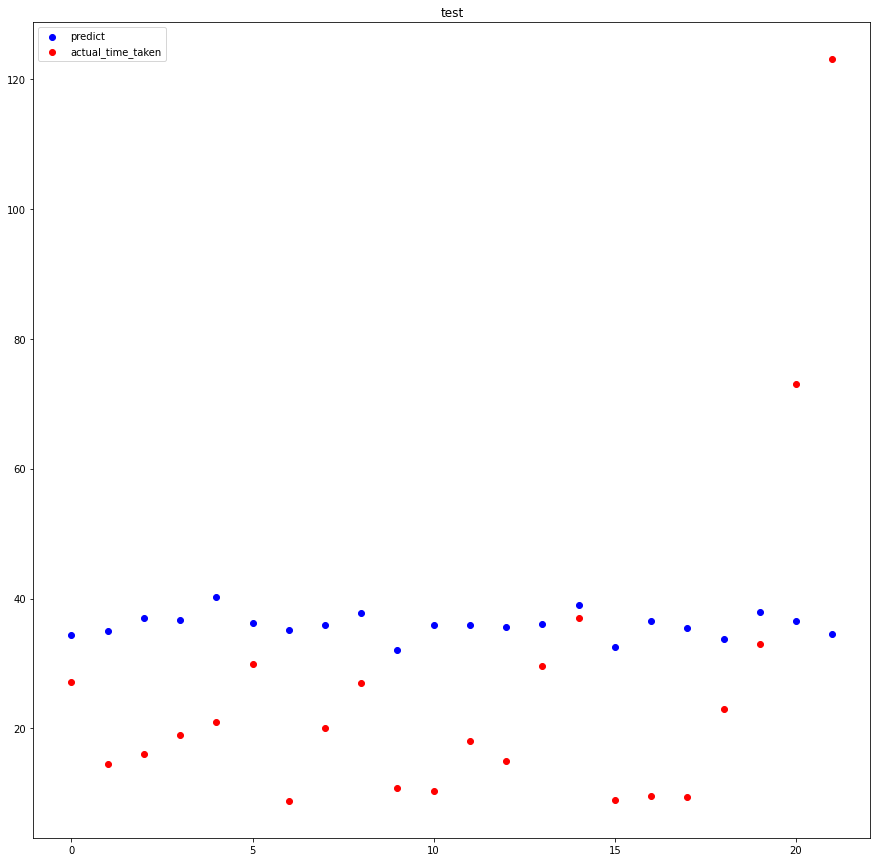

gbm prediction progress: |████████████████████████████████████████████████| 100%


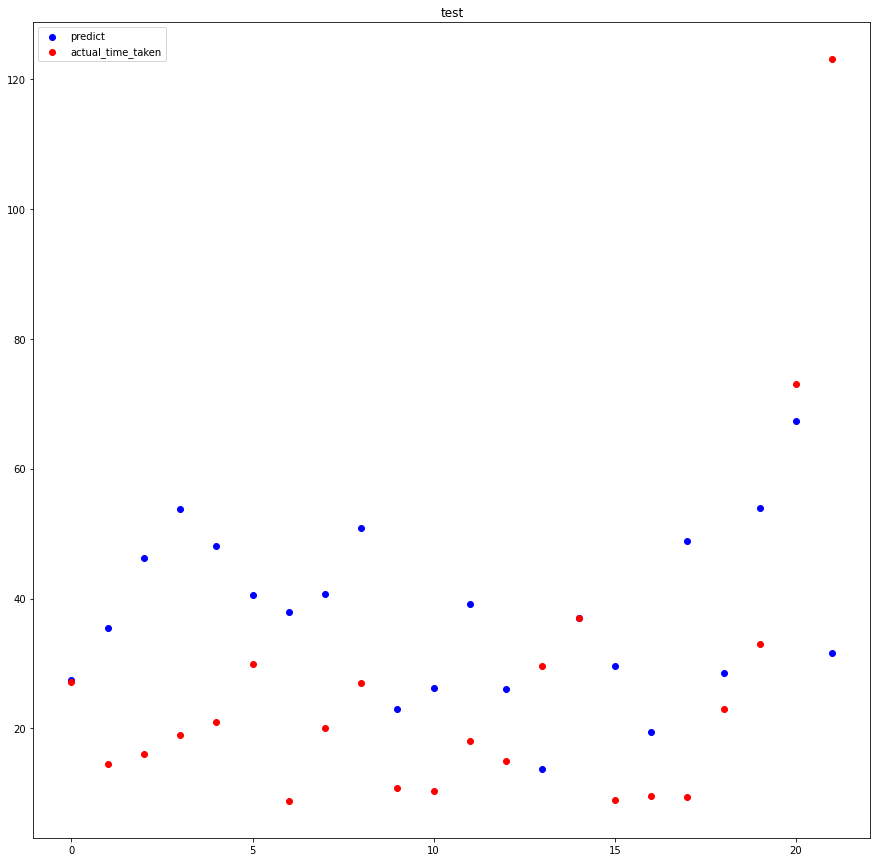

deeplearning prediction progress: |███████████████████████████████████████| 100%


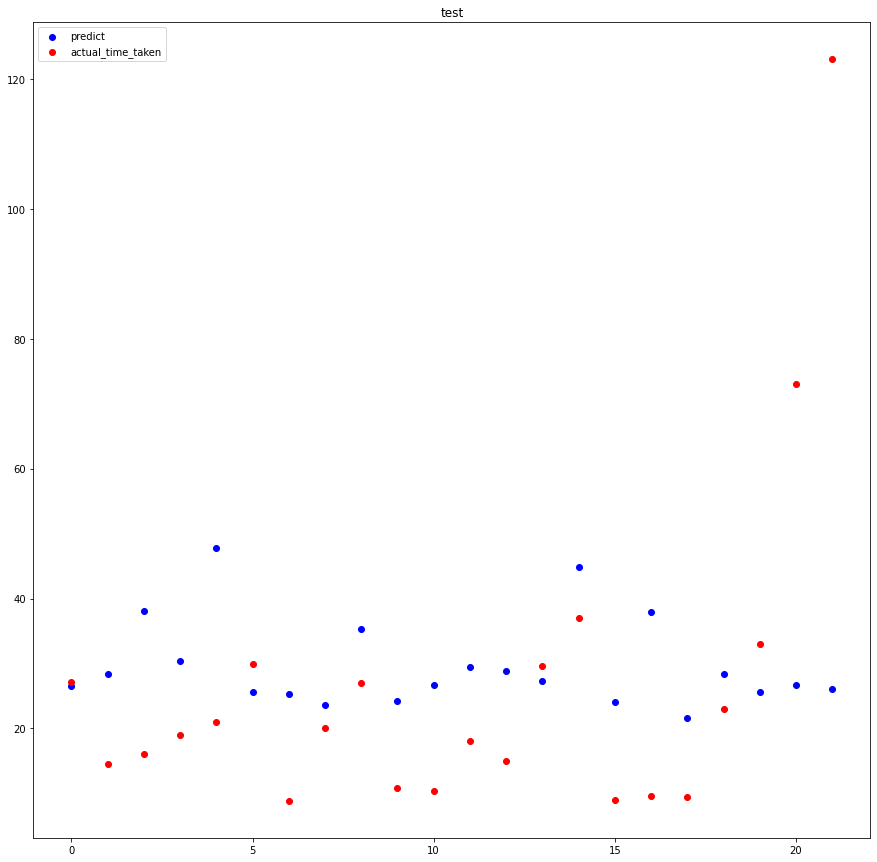

deeplearning prediction progress: |███████████████████████████████████████| 100%


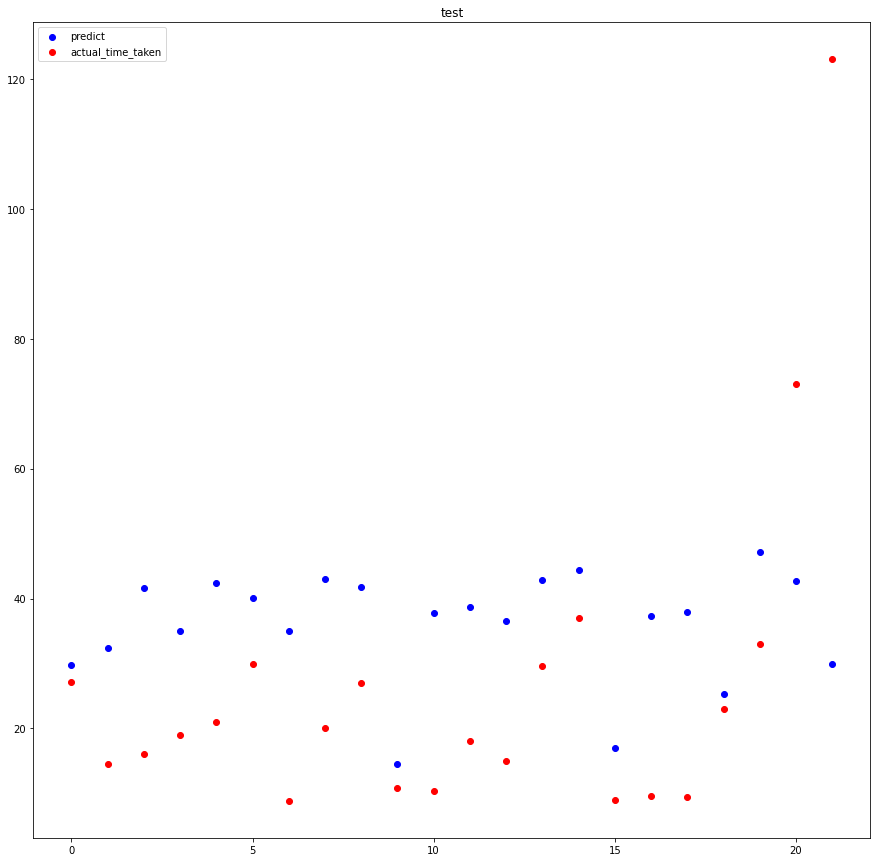

gbm prediction progress: |████████████████████████████████████████████████| 100%


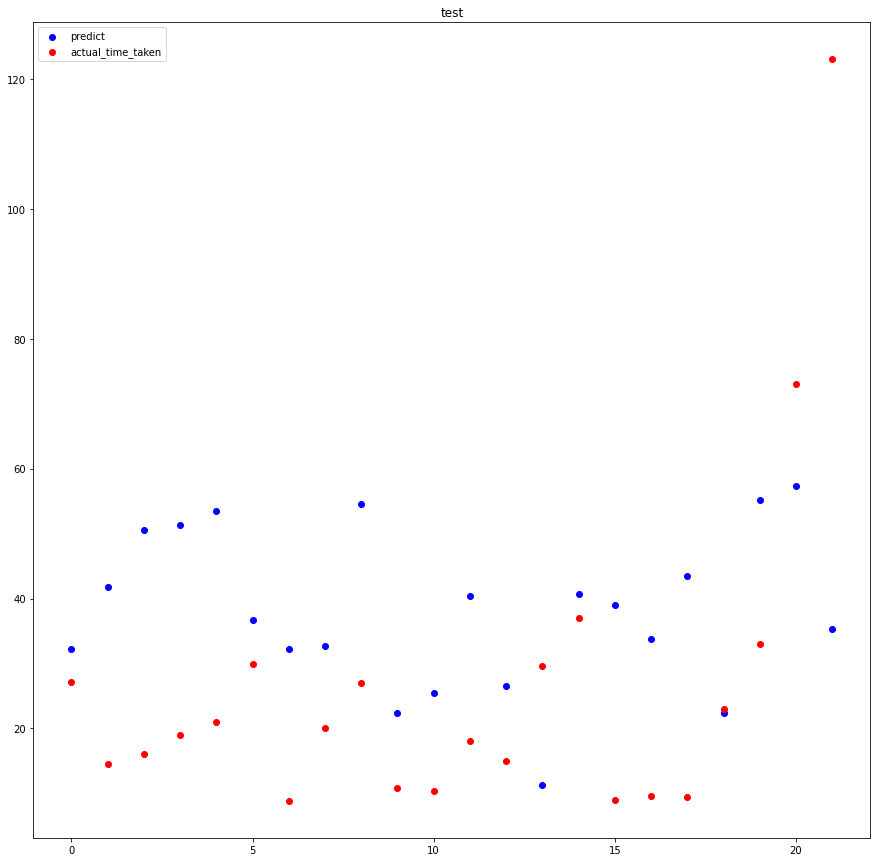

deeplearning prediction progress: |███████████████████████████████████████| 100%


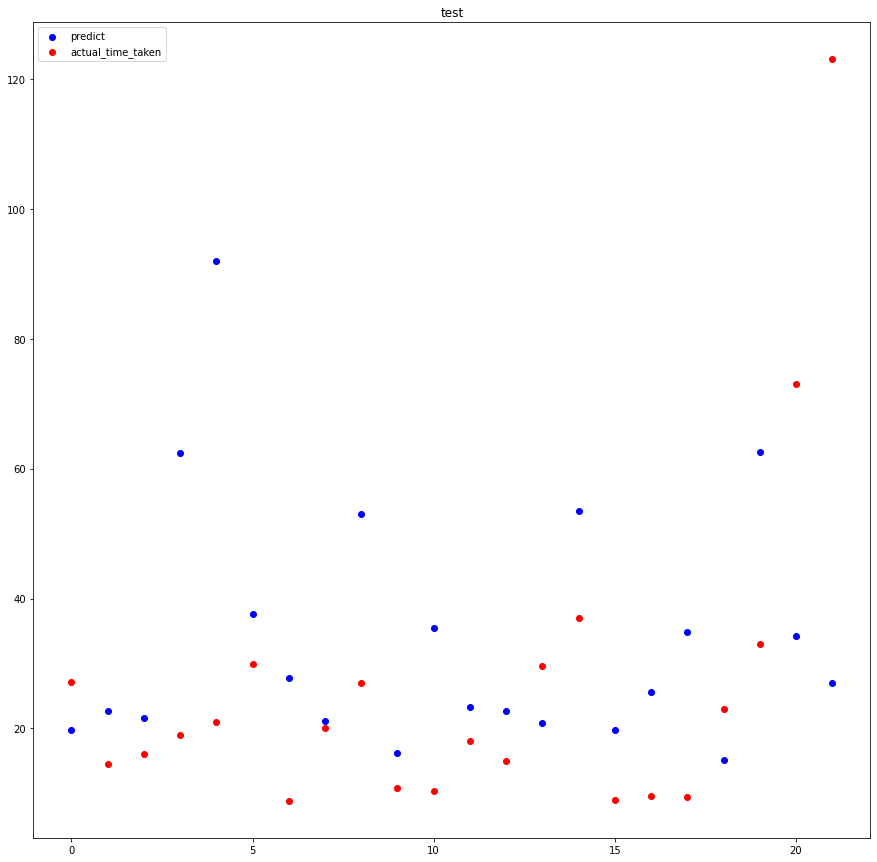

gbm prediction progress: |████████████████████████████████████████████████| 100%


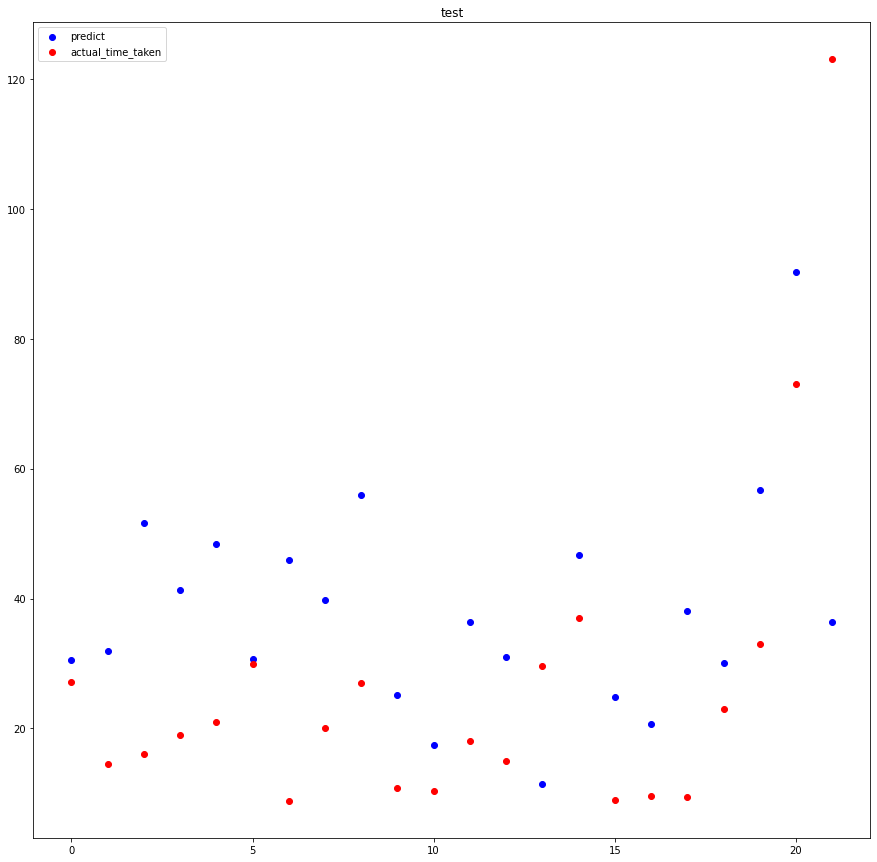

gbm prediction progress: |████████████████████████████████████████████████| 100%


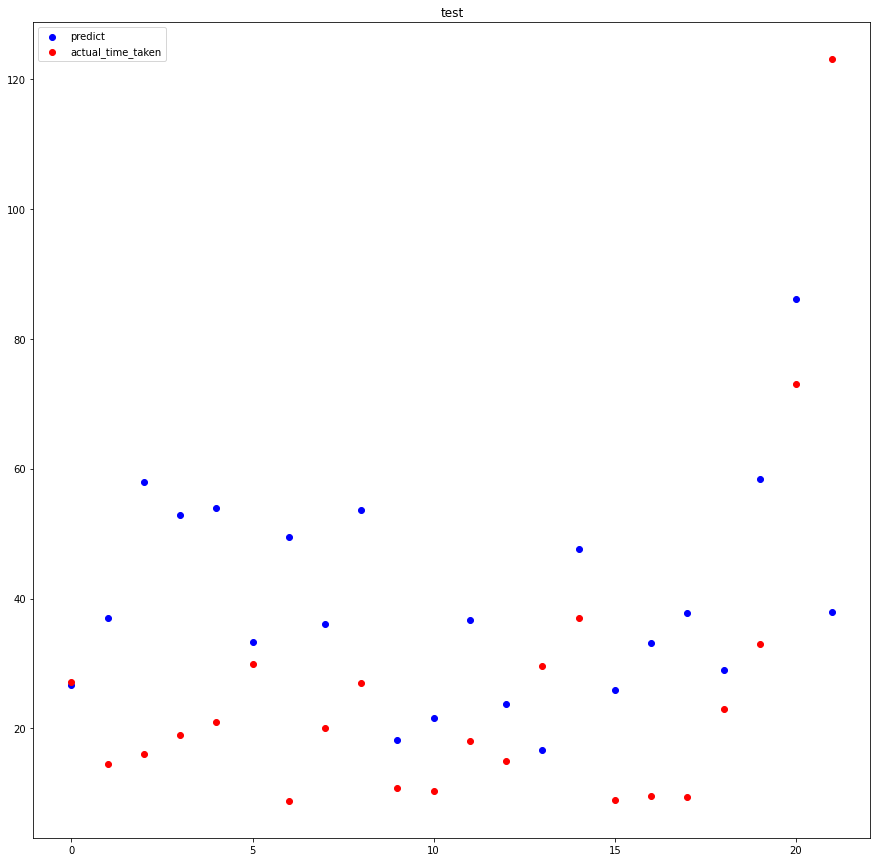

gbm prediction progress: |████████████████████████████████████████████████| 100%


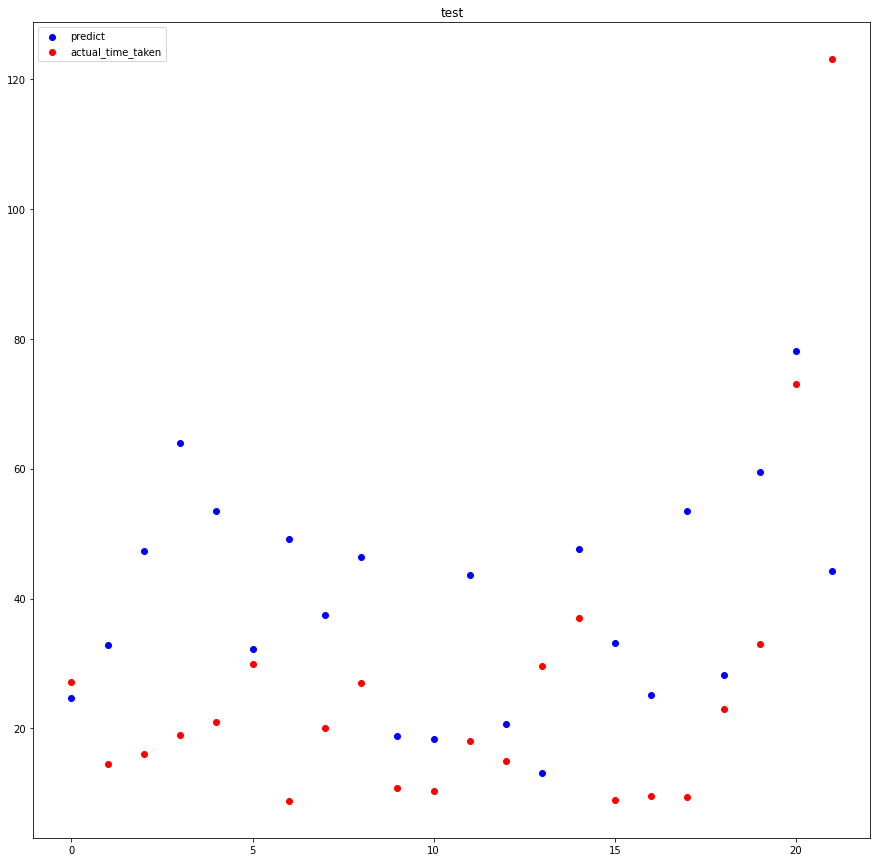

gbm prediction progress: |████████████████████████████████████████████████| 100%


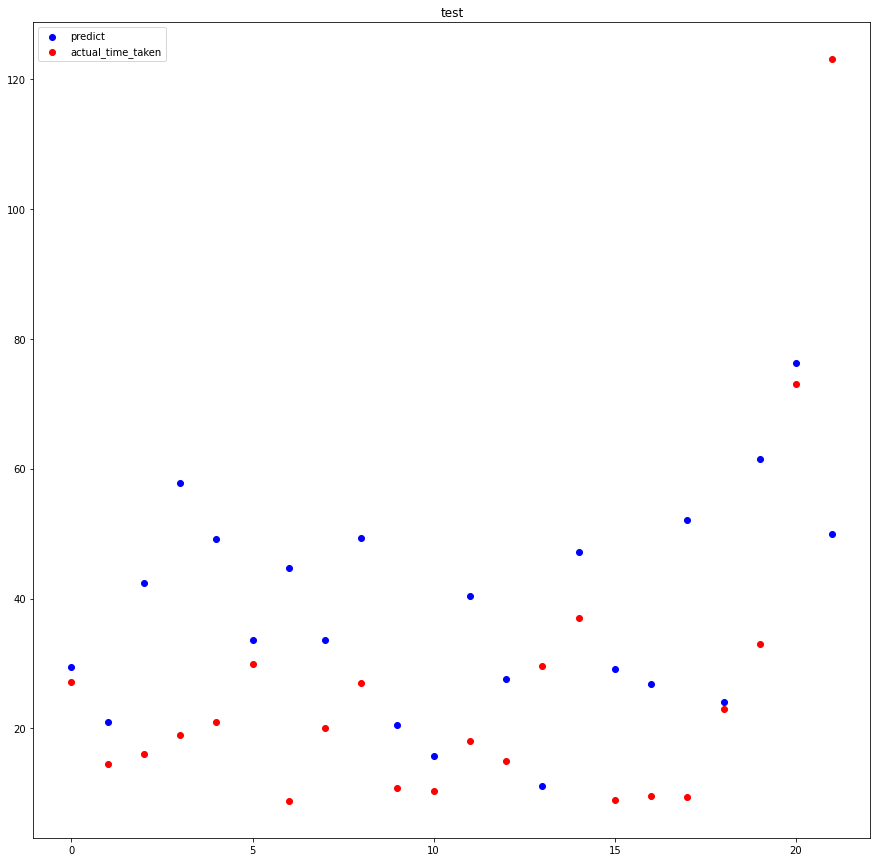

deeplearning prediction progress: |███████████████████████████████████████| 100%


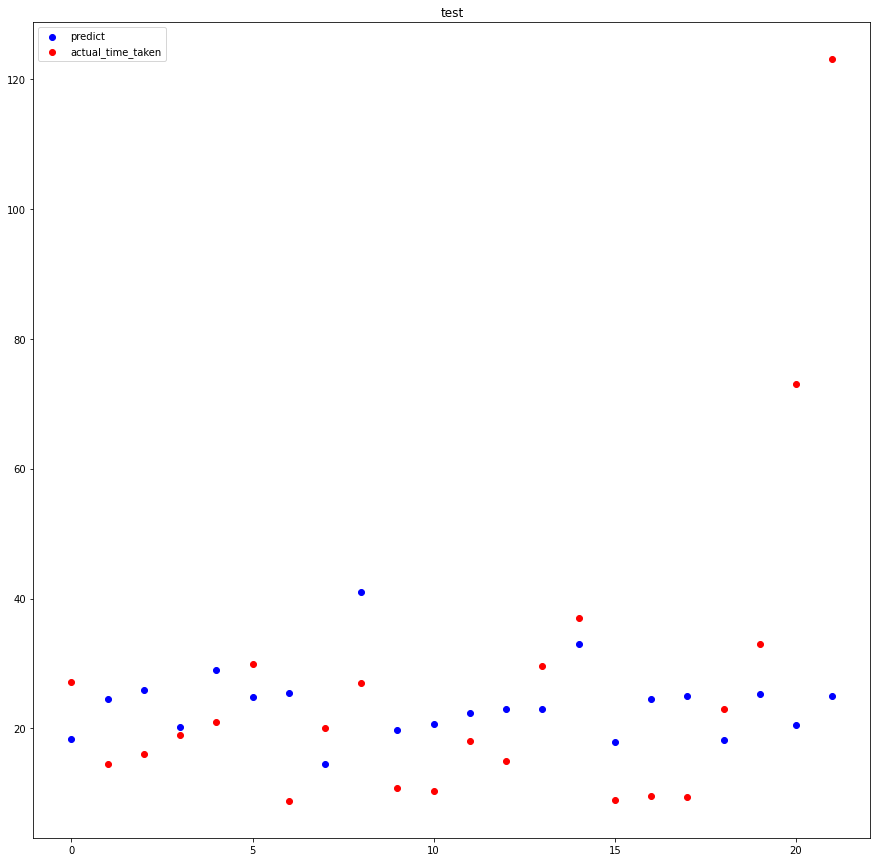

gbm prediction progress: |████████████████████████████████████████████████| 100%


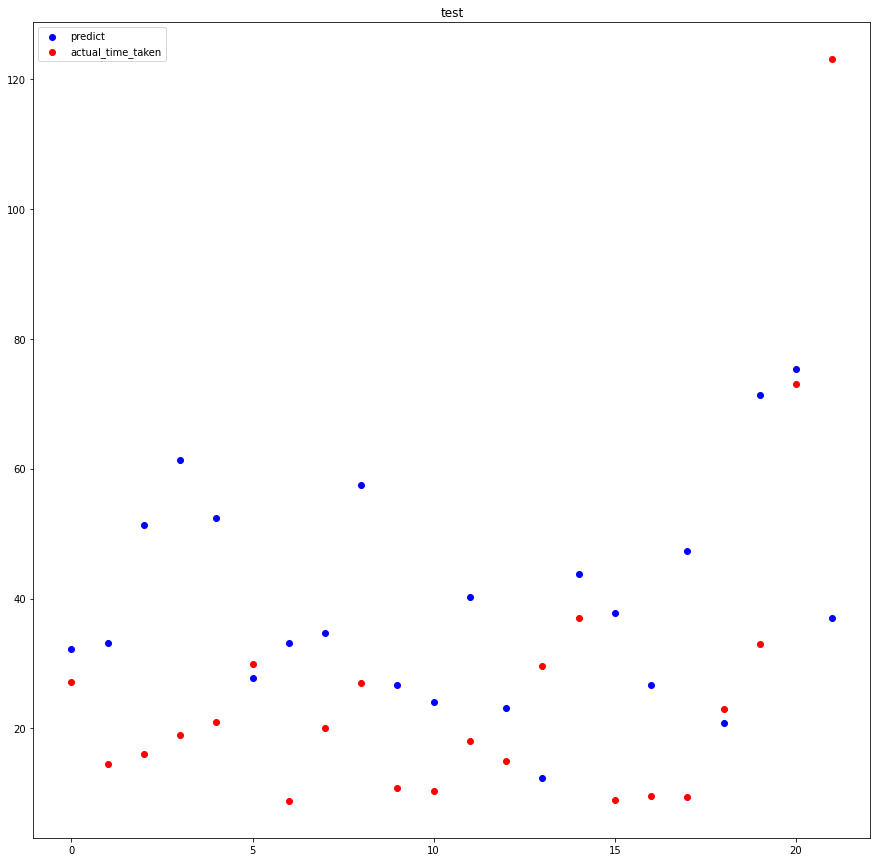

gbm prediction progress: |████████████████████████████████████████████████| 100%


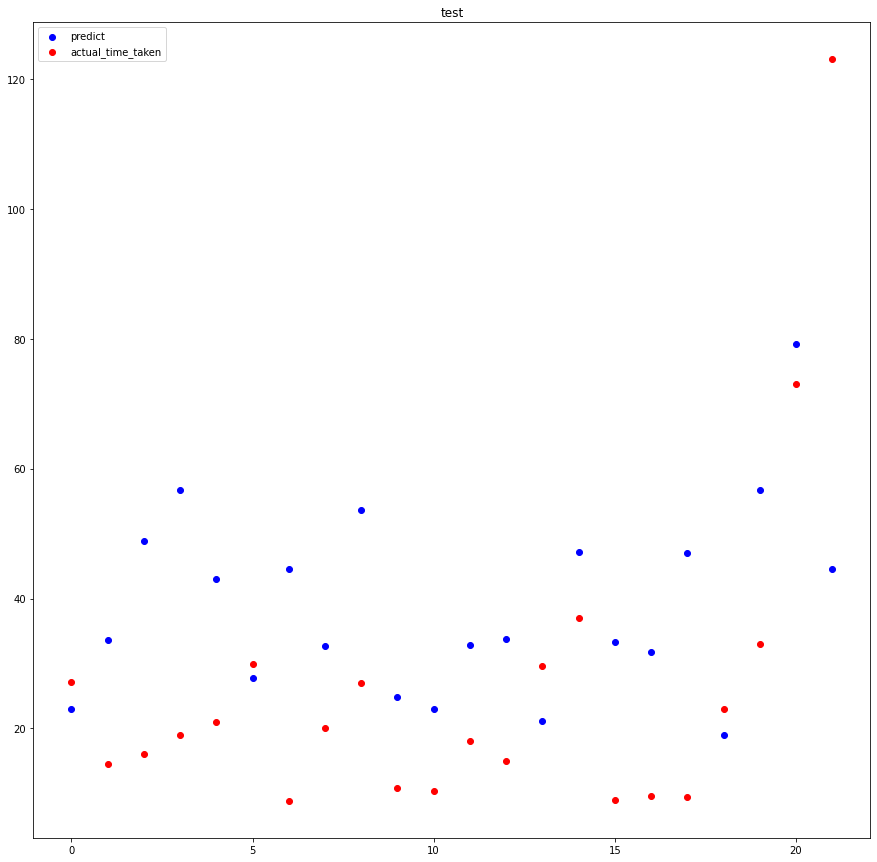

drf prediction progress: |████████████████████████████████████████████████| 100%


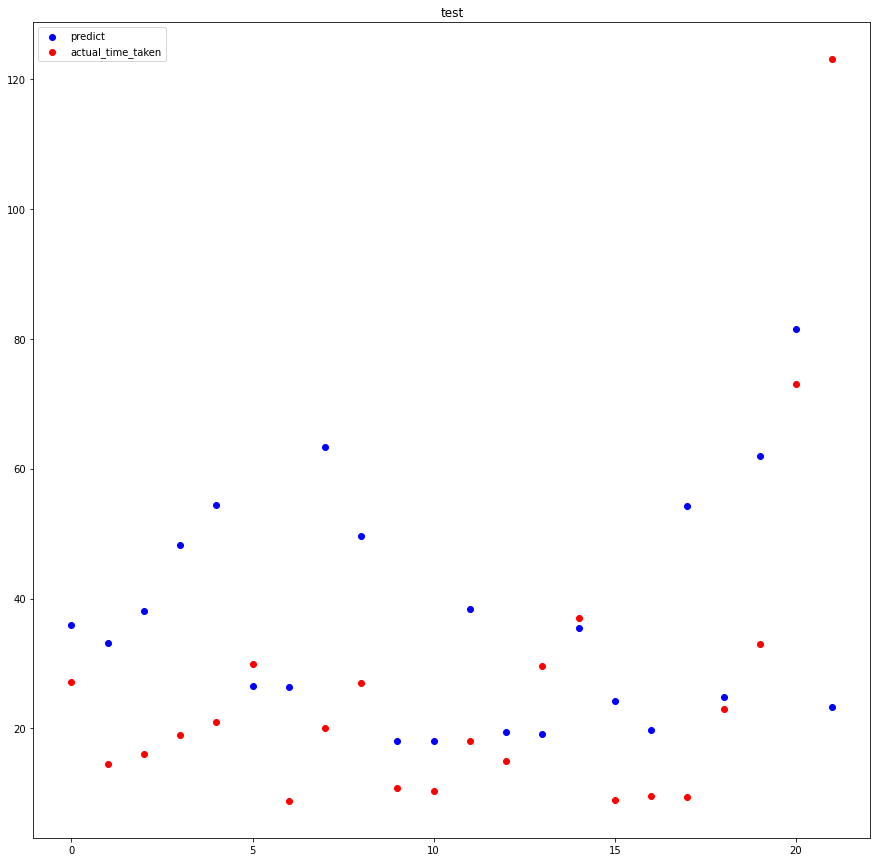

gbm prediction progress: |████████████████████████████████████████████████| 100%


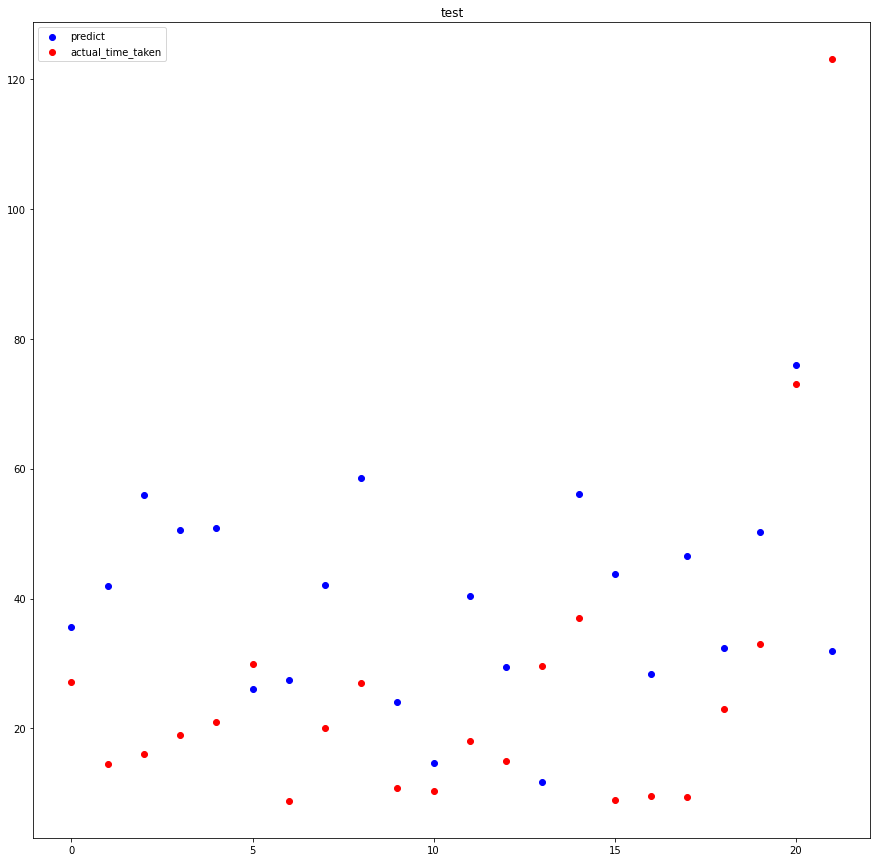

drf prediction progress: |████████████████████████████████████████████████| 100%


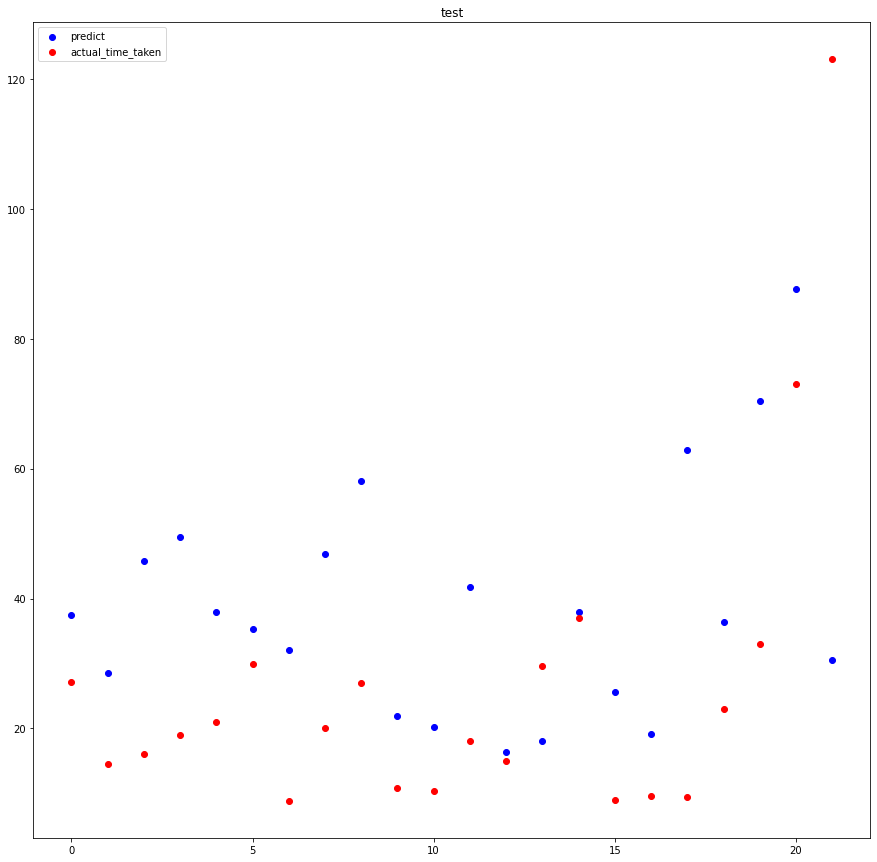

gbm prediction progress: |████████████████████████████████████████████████| 100%


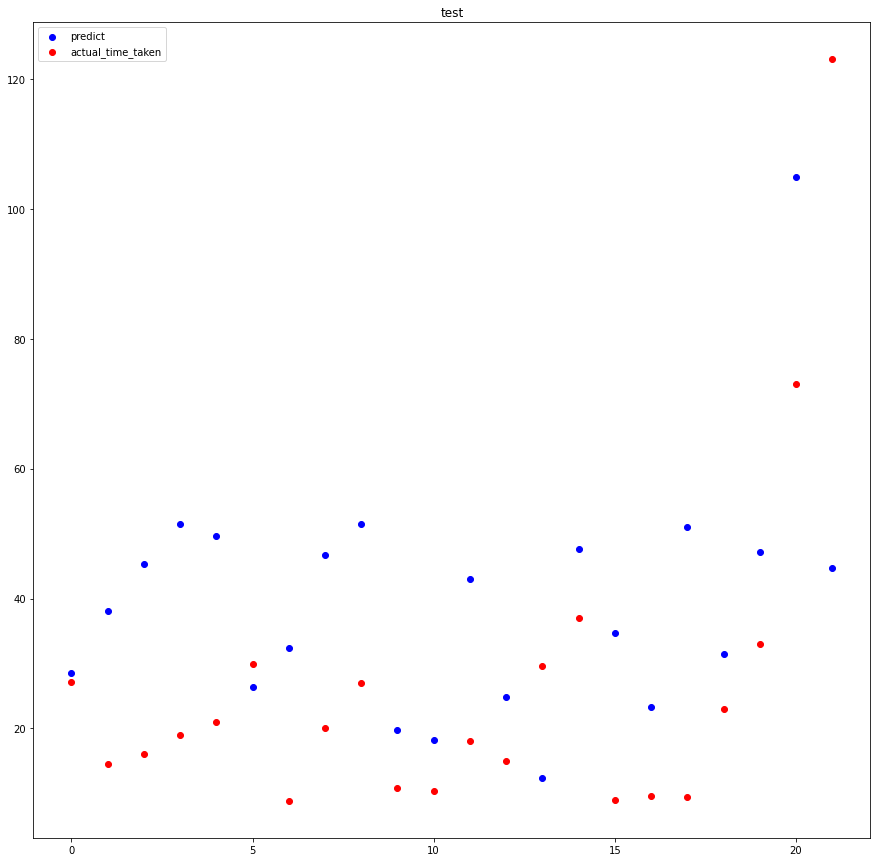

deeplearning prediction progress: |███████████████████████████████████████| 100%


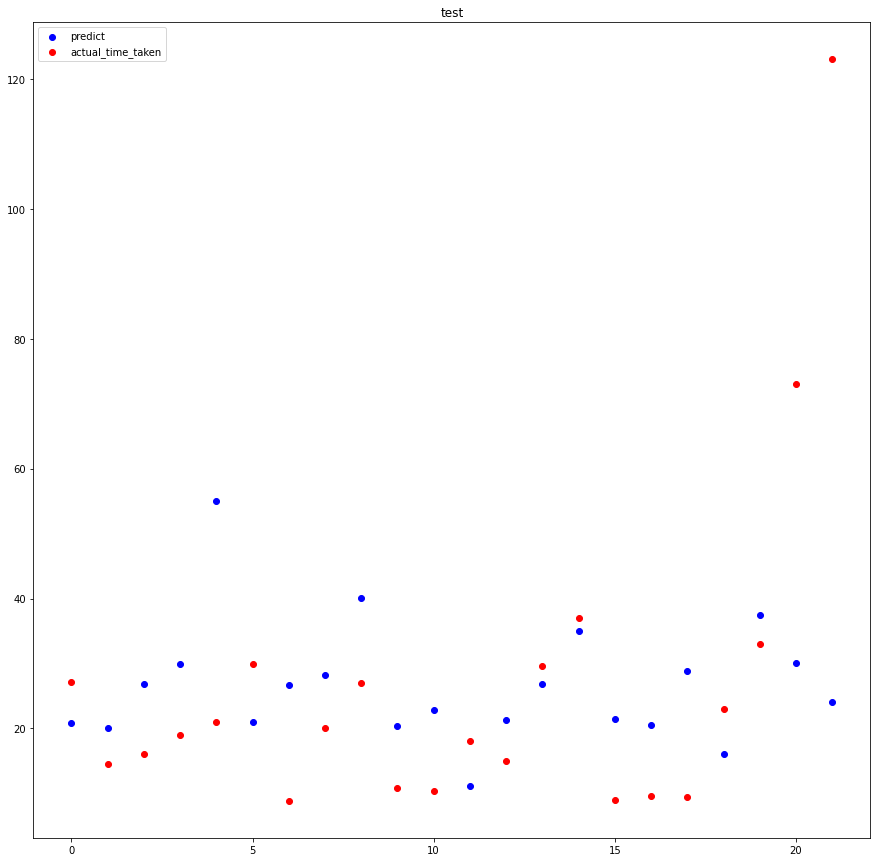

deeplearning prediction progress: |███████████████████████████████████████| 100%


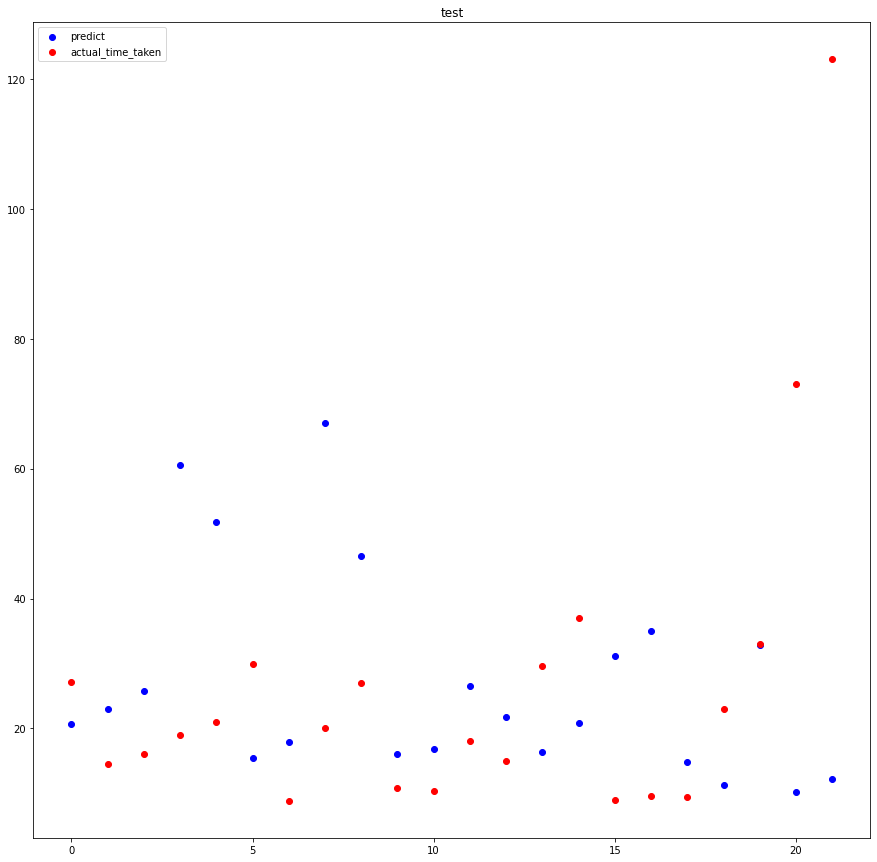

gbm prediction progress: |████████████████████████████████████████████████| 100%


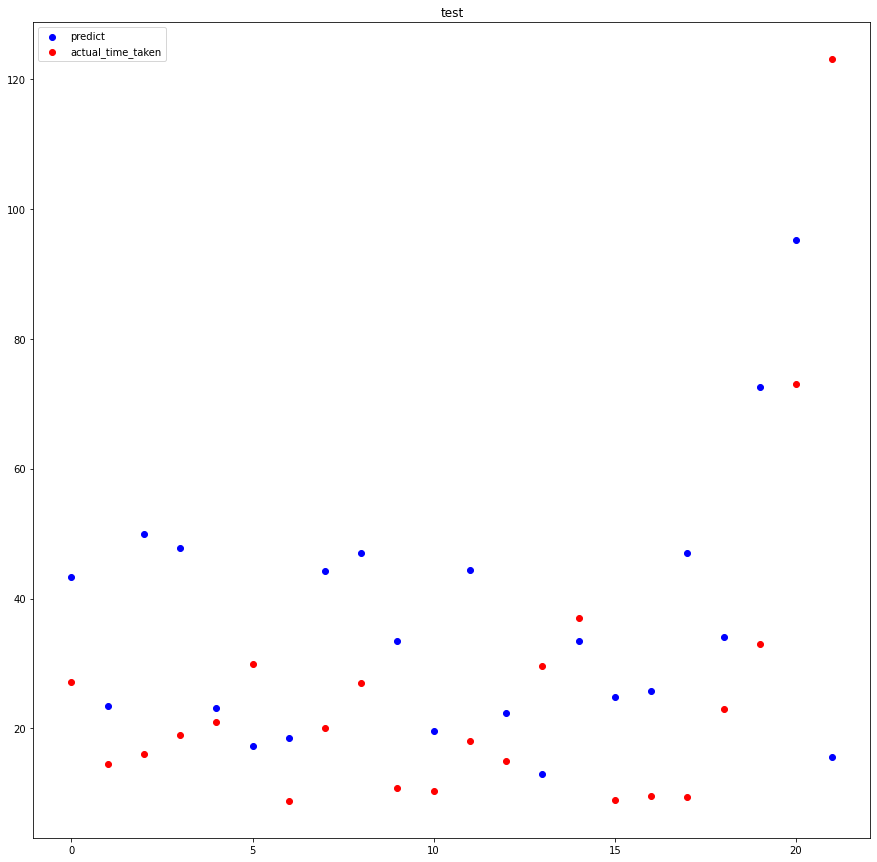

deeplearning prediction progress: |███████████████████████████████████████| 100%


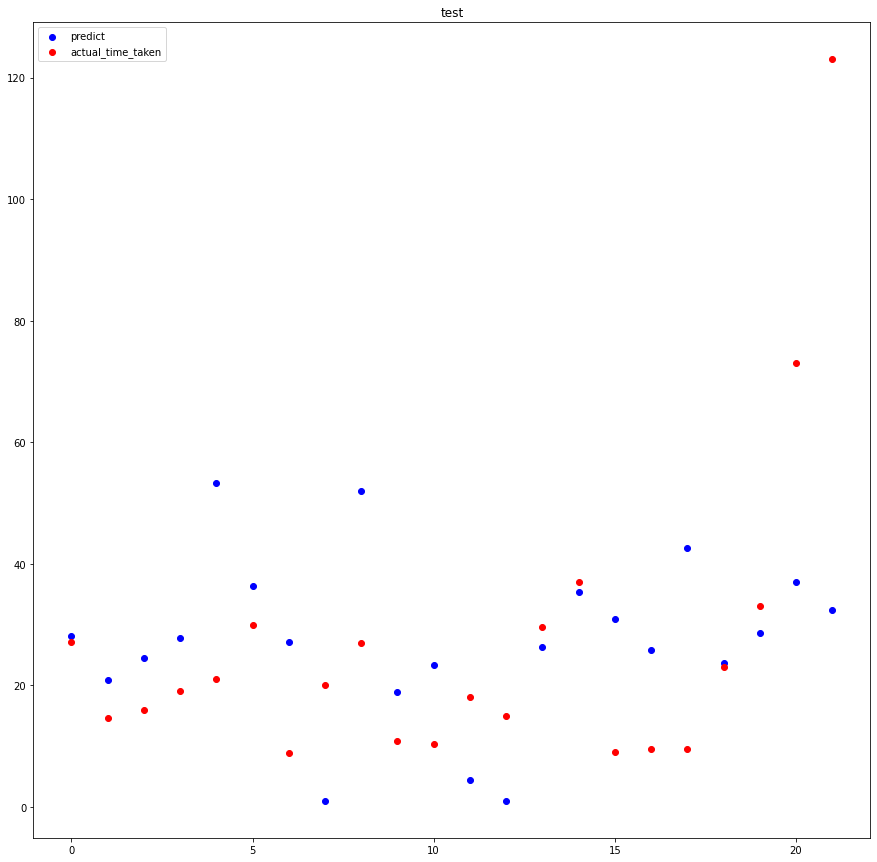

deeplearning prediction progress: |███████████████████████████████████████| 100%


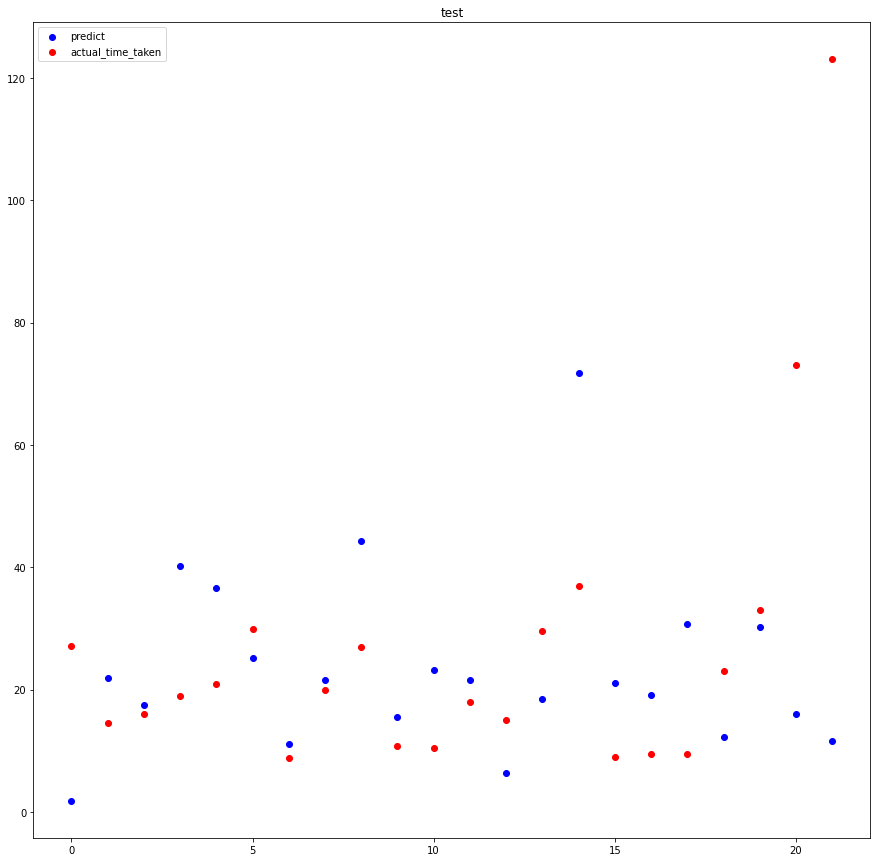

deeplearning prediction progress: |███████████████████████████████████████| 100%


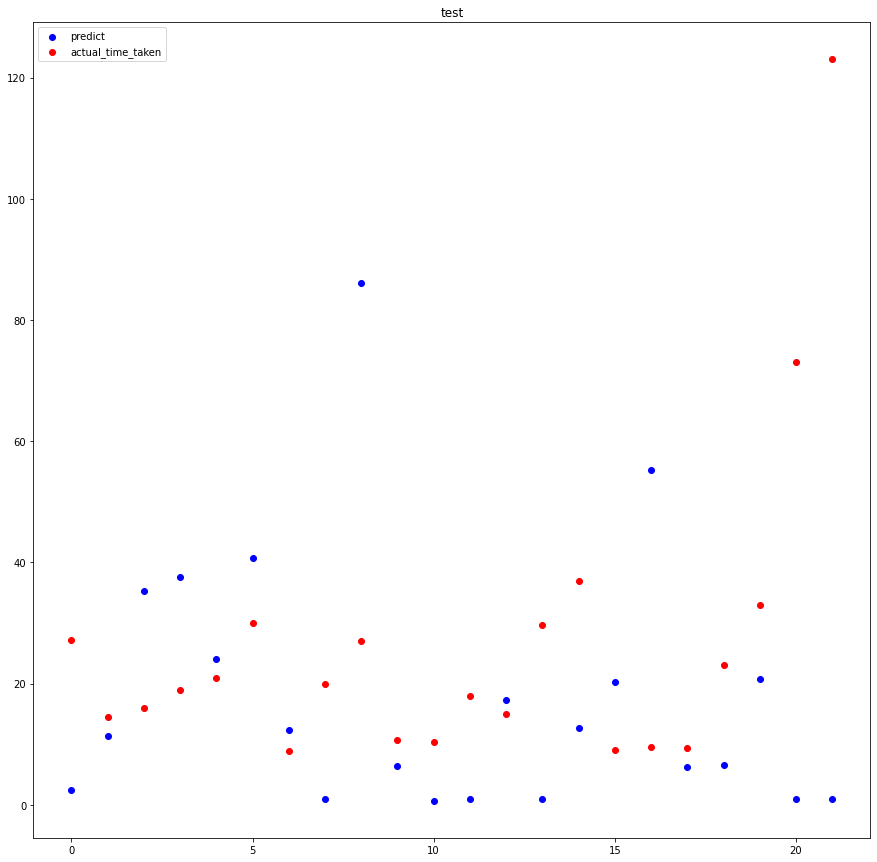

deeplearning prediction progress: |███████████████████████████████████████| 100%


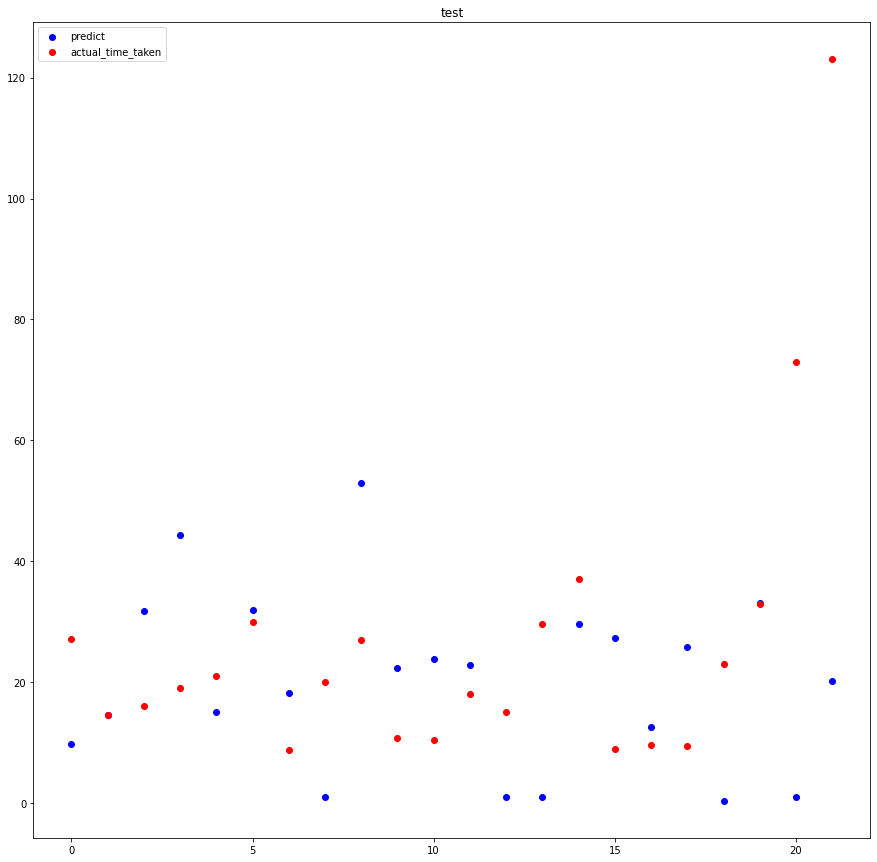

In [49]:
for i in range(25):
    model = h2o.get_model(lb[i,'model_id'])
    preds = model.predict(test)
    pd_preds = preds.as_data_frame()
    pd_test = test.as_data_frame()
    pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']
    pd_preds.loc[(pd_preds.predict < 0),'predict']=1
    plotGraphandSave(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken','test', i)
    

In [50]:
model = h2o.get_model(lb[22,'model_id'])

In [51]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__2_AutoML_20220213_050900_model_1


Status of Neuron Layers: predicting refactoring_perc_time_taken, regression, gaussian distribution, Quadratic loss, 10,201 weights/biases, 145.6 KB, 592,620 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,151,Input,5,,,,,,,,,
1,,2,50,RectifierDropout,0,0,0,0.110007,0.108026,0,0.0213796,0.230415,-0.0700547,0.400155
2,,3,50,RectifierDropout,0,0,0,0.02766,0.0361803,0,-0.103218,0.222212,1.17724,0.452385
3,,4,1,Linear,,0,0,0.00299042,0.00230091,0,0.0142476,0.292581,0.221928,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 125.80861907197668
RMSE: 11.216444136711807
MAE: 5.650356769589767
RMSLE: 0.556615282719664
Mean Residual Deviance: 125.80861907197668

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 2622.648191320643
RMSE: 51.211797384202825
MAE: 34.80627387727916
RMSLE: NaN
Mean Residual Deviance: 2622.648191320643

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,34.753956,8.088133,37.237614,24.125547,41.42667,42.451706,28.528244
1,mean_residual_deviance,2613.1506,1295.2557,4330.305,1187.9253,3258.2737,2806.3064,1482.9426
2,mse,2613.1506,1295.2557,4330.305,1187.9253,3258.2737,2806.3064,1482.9426
3,r2,-1.4108968,1.4427757,-3.984435,-0.87196976,-0.5846391,-0.8139608,-0.7994795
4,residual_deviance,2613.1506,1295.2557,4330.305,1187.9253,3258.2737,2806.3064,1482.9426
5,rmse,49.767242,13.056234,65.80505,34.466293,57.08129,52.974583,38.508995
6,rmsle,0.9481906,0.0304795,NaN,0.9697429,NaN,NaN,0.92663836



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-02-13 05:14:13,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-02-13 05:14:13,59.089 sec,24285 obs/sec,10.0,1,1190.0,36.402846,1325.167223,25.346309,-0.036473
2,,2022-02-13 05:14:18,1 min 4.094 sec,36517 obs/sec,1550.0,155,184450.0,8.449535,71.394646,4.260415,0.944159
3,,2022-02-13 05:14:23,1 min 9.111 sec,38661 obs/sec,3270.0,327,389130.0,10.315114,106.401574,4.486491,0.916779
4,,2022-02-13 05:14:28,1 min 13.899 sec,39907 obs/sec,4980.0,498,592620.0,11.216444,125.808619,5.650357,0.901599



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,num_dependency_mean,1.000000,1.000000,0.018730
1,dit_mean,0.663324,0.663324,0.012424
2,protectedMethods_mean,0.626636,0.626636,0.011737
3,dit_min,0.616131,0.616131,0.011540
4,protectedMethods_min,0.614159,0.614159,0.011503
5,dit_max,0.596732,0.596732,0.011177
6,nosi_min,0.594647,0.594647,0.011137
7,mathOperationsQty_min,0.592096,0.592096,0.011090
8,loopQty_mean,0.591144,0.591144,0.011072
9,loopQty_min,0.587258,0.587258,0.010999



See the whole table with table.as_data_frame()


In [52]:
preds = model.predict(test)

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [53]:
preds

predict
1.84091
21.8444
17.4171
40.205
36.5787
25.1877
11.1076
21.6316
44.2948
15.6066


In [54]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

15.986657    1
12.299560    1
40.204990    1
23.257408    1
15.606613    1
11.571537    1
18.496831    1
30.305329    1
17.417064    1
1.840907     1
21.631586    1
21.844428    1
21.571500    1
6.303391     1
36.578717    1
21.072828    1
71.780485    1
25.187658    1
44.294844    1
19.057097    1
30.768652    1
11.107602    1
Name: predict, dtype: int64

In [55]:
train.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
11,11,11,0,8,8,8,0,2,2,2,0,9,9,9,0,15,15,15,0,6,6,6,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,63,63,63,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,6,6,6,0,2,2,2,0,4,4,4,0,0,0,0,0,4,4,4,0,3,3,3,0,0,0,0,0,0,0,0,0,1,1,1,0,58,58,58,0,17,17,17,0,85,61,15
38,38,38,0,57,57,57,0,1,1,1,0,81,81,81,0,0,0,0,0,45,45,45,0,1,1,1,0,42,42,42,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,1,1,1,0,0,0,0,0,12,12,12,0,0,0,0,0,0,0,0,0,5,5,5,0,0,0,0,0,32,32,32,0,576,576,576,0,2,2,2,0,6,6,6,0,1,1,1,0,5,5,5,0,26,26,26,0,13,13,13,0,159,159,159,0,100,100,100,0,85,85,85,0,90,90,90,0,1,1,1,0,2,2,2,0,0,0,0,0,2,2,2,0,279,279,279,0,17,17,17,0,322,764,10
4,4,4,0,15,15,15,0,1,1,1,0,6,6,6,0,18,18,18,0,12,12,12,0,1,1,1,0,11,11,11,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,64,64,64,0,12,12,12,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,7,7,7,0,0,0,0,0,4,4,4,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,108,108,108,0,1,1,1,0,371,115,9.4875
4.42857,2,9,2.50713,1.28571,0,3,1.38013,1.71429,1,2,0.48795,2,0,5,2.23607,1,0,3,1.41421,1.28571,0,3,1.38013,0,0,0,0,0.857143

{'whiskers': [<matplotlib.lines.Line2D at 0x1824aef9f98>,
 'caps': [<matplotlib.lines.Line2D at 0x1824aefb710>,
 'boxes': [<matplotlib.lines.Line2D at 0x1824aef9e48>],
 'medians': [<matplotlib.lines.Line2D at 0x1824aefbe10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1824aed31d0>],
 'means': []}

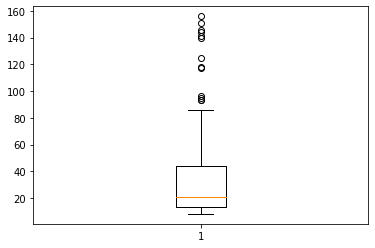

In [56]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1824aad0048>,
 'caps': [<matplotlib.lines.Line2D at 0x1824aade400>,
 'boxes': [<matplotlib.lines.Line2D at 0x1824aad0588>],
 'medians': [<matplotlib.lines.Line2D at 0x1824aade278>],
 'fliers': [<matplotlib.lines.Line2D at 0x1824aab26a0>],
 'means': []}

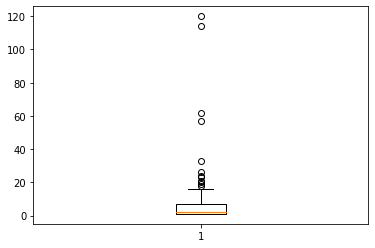

In [57]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [58]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x1824a647080>,
 'caps': [<matplotlib.lines.Line2D at 0x1824a647c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1824a647860>],
 'medians': [<matplotlib.lines.Line2D at 0x1824a642cf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1824a642320>],
 'means': []}

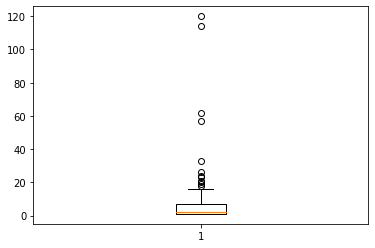

In [59]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x18248f8f240>,
 'caps': [<matplotlib.lines.Line2D at 0x18248f7c4e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18248f8f358>],
 'medians': [<matplotlib.lines.Line2D at 0x18248f986a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18248f980b8>],
 'means': []}

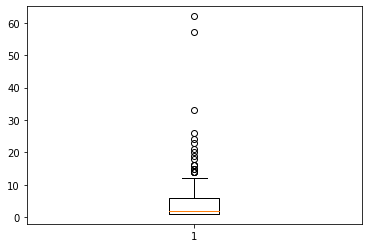

In [60]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [61]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [62]:
pd_preds.head()

,predict,actual_time_taken
0,1.840907,27.153976
1,21.844428,14.557292
2,17.417064,16.000000
3,40.204990,19.000000
4,36.578717,21.000000


In [63]:
pd_preds.loc[(pd_preds.predict < 0),'predict']=1

In [64]:
pd_preds

,predict,actual_time_taken
0,1.840907,27.153976
1,21.844428,14.557292
2,17.417064,16.000000
3,40.204990,19.000000
4,36.578717,21.000000
5,25.187658,29.985836
6,11.107602,8.863636
7,21.631586,20.000000
8,44.294844,27.000000
9,15.606613,10.775510


{'whiskers': [<matplotlib.lines.Line2D at 0x182481dc2e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1824819fb00>,
 'boxes': [<matplotlib.lines.Line2D at 0x182481dc278>],
 'medians': [<matplotlib.lines.Line2D at 0x1824819fe48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1824819f1d0>],
 'means': []}

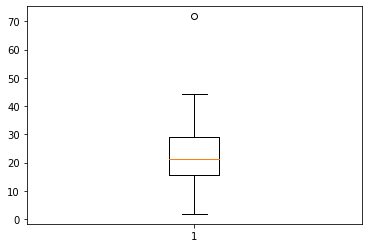

In [65]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x18245e5f208>,
 'caps': [<matplotlib.lines.Line2D at 0x18245a43080>,
 'boxes': [<matplotlib.lines.Line2D at 0x18245e5fb70>],
 'medians': [<matplotlib.lines.Line2D at 0x18245a43390>],
 'fliers': [<matplotlib.lines.Line2D at 0x18245a43c50>],
 'means': []}

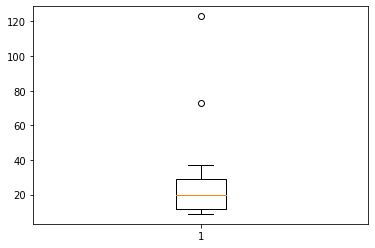

In [66]:
plt.boxplot(pd_preds['actual_time_taken'])

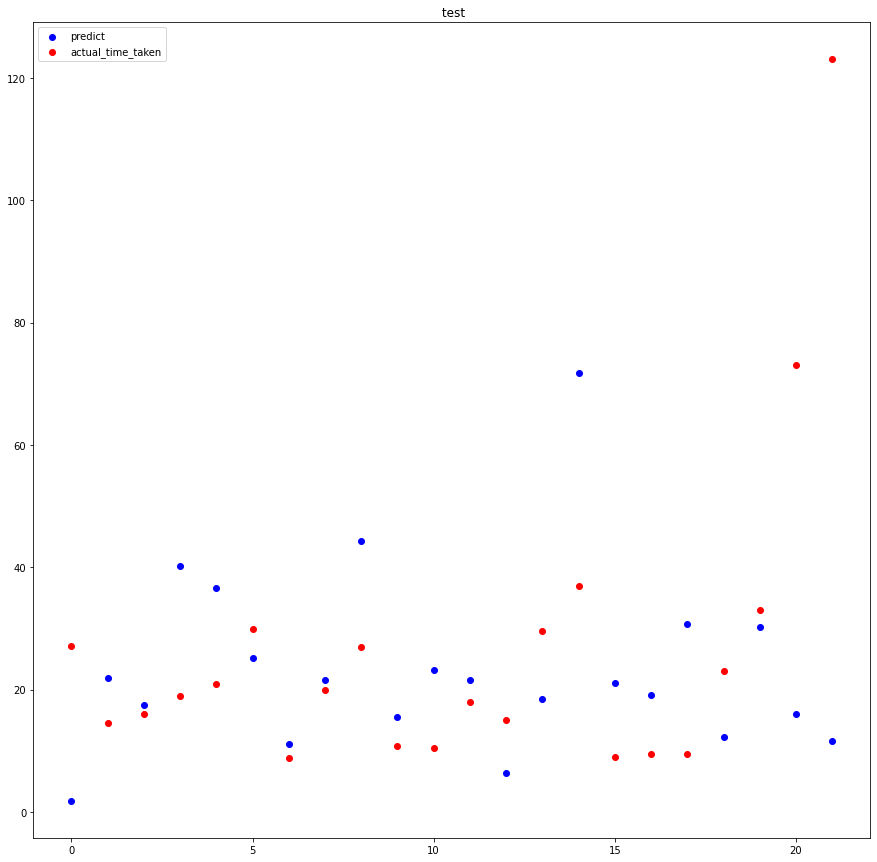

In [67]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken',' test')

In [68]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


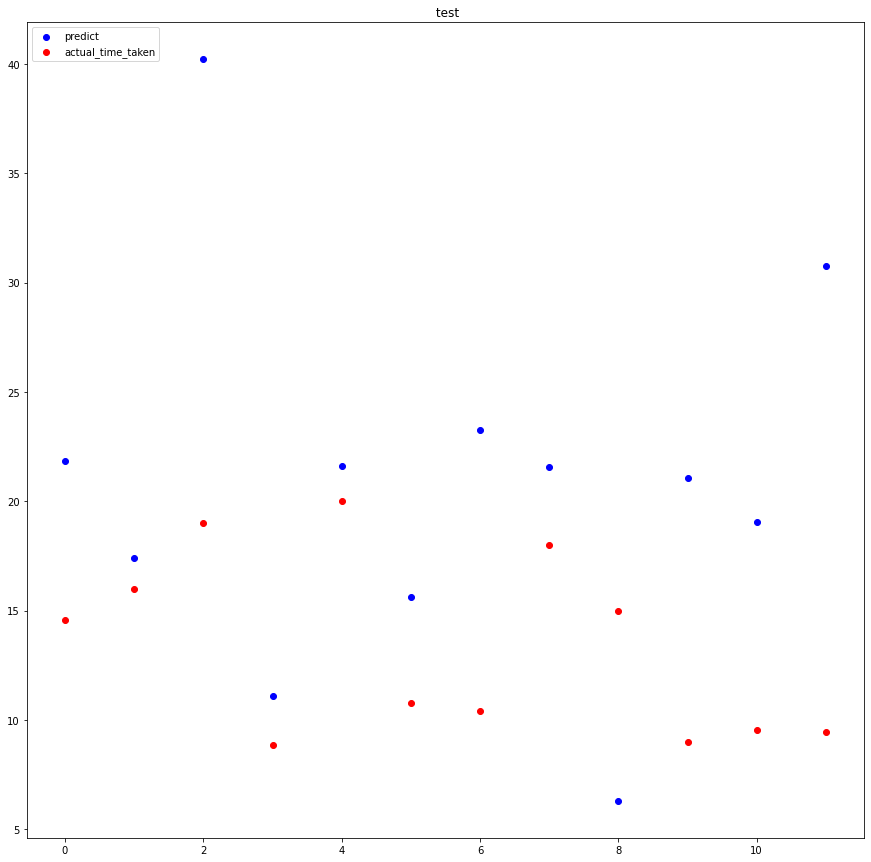

In [69]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

In [70]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

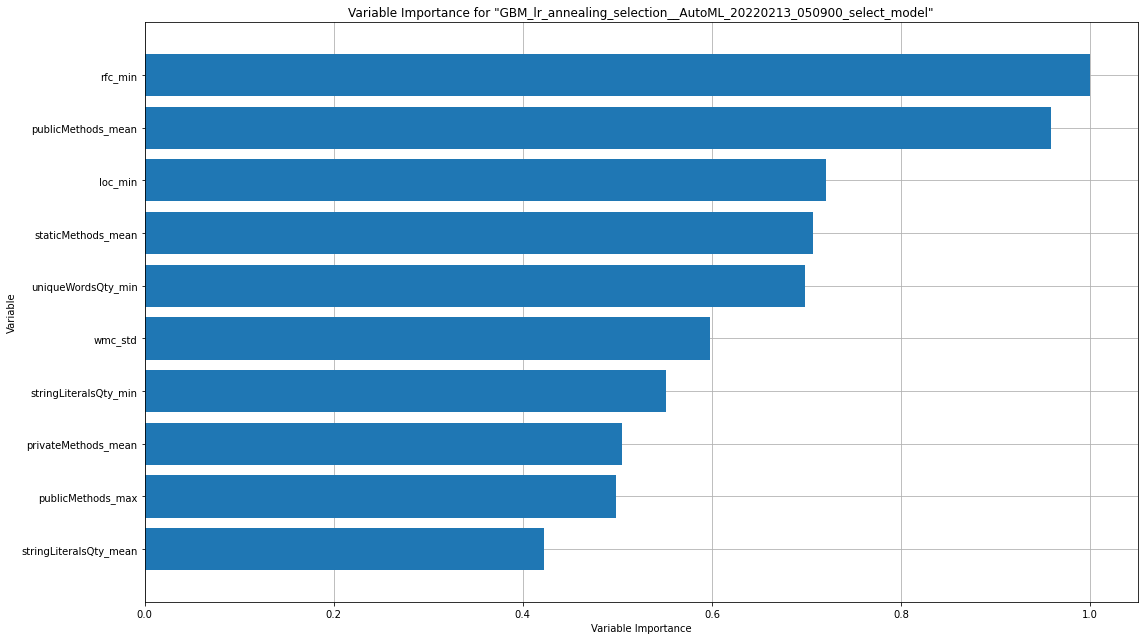

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

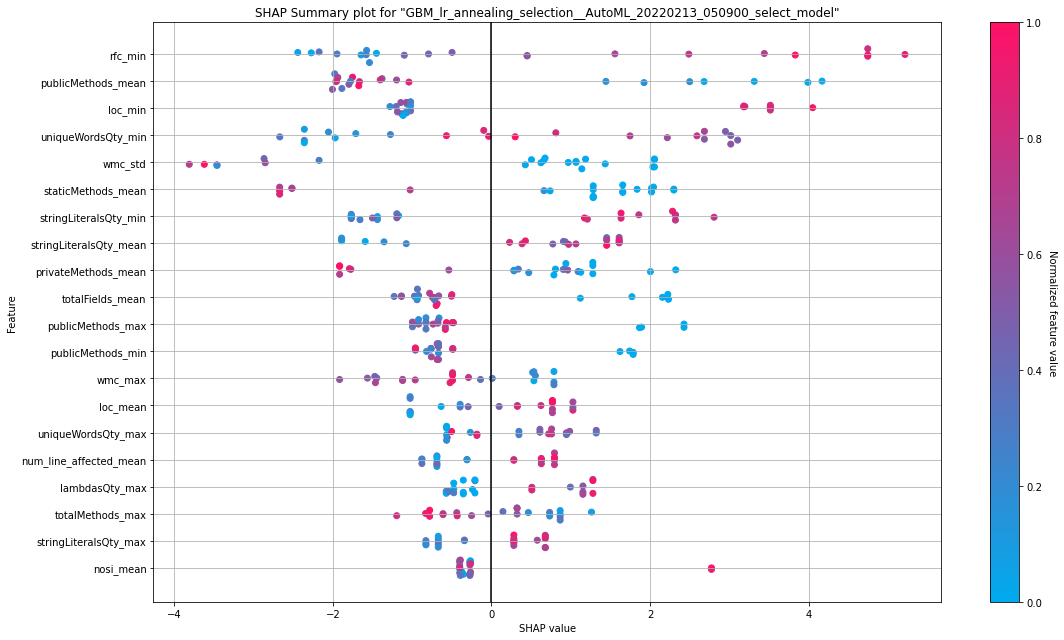

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

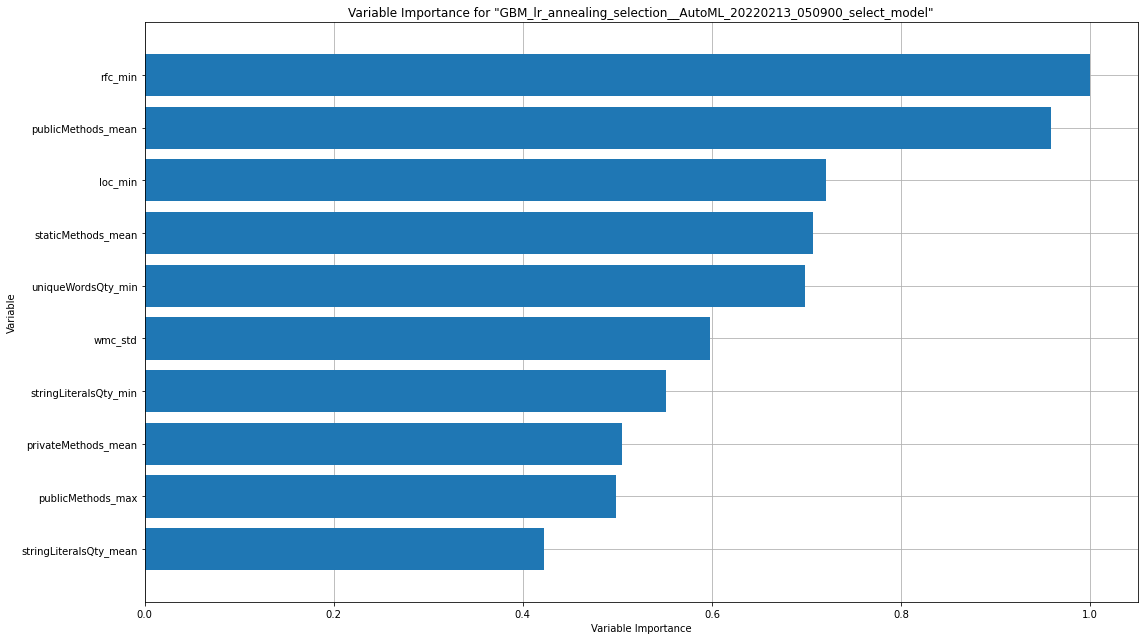

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

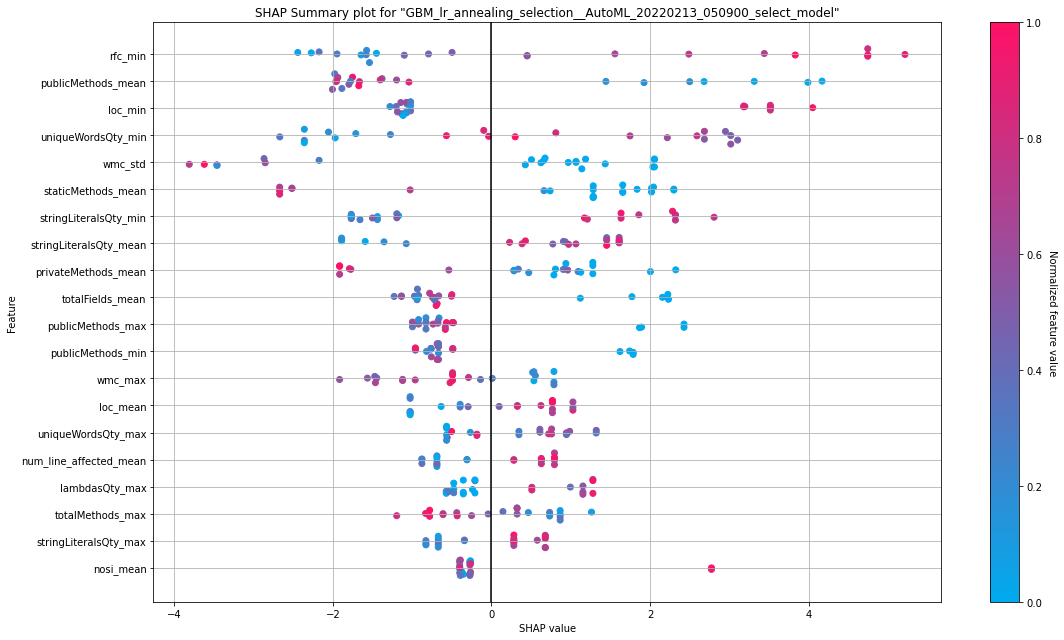

In [71]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [ ]:
## Test calling of model

model_path = "models/EffortEstimationModelv2/GBM_lr_annealing_selection__AutoML_20220206_202721_select_model"
saved_model = h2o.load_model(model_path)

In [ ]:
preds_read_model = model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [ ]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()